In [1]:
import openmeteo_requests
import pandas as pd
import requests_cache
import matplotlib.pyplot as plt
from scipy.signal import stft
from datetime import timedelta, date, datetime

from retry_requests import retry
import plotly.express as px
import plotly.graph_objects as go
from scipy.fft import dct, idct
import numpy as np
import os
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')

from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from dotenv import load_dotenv
from pyspark.sql import SparkSession, functions
from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
# Setting the environment for PySpark
load_dotenv()

HADOOP_PATH = os.getenv("HADOOP_PATH")

os.environ["JAVA_HOME"] = r"C:\Program Files\Microsoft\jdk-11.0.28.6-hotspot" 
os.environ["PYSPARK_HADOOP_VERSION"] = "without"
os.environ["HADOOP_HOME"] = HADOOP_PATH
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"

In [3]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [4]:
cities = {
    'Oslo':
        {"price_area_code": "NO1",
         "longitude": 10.7461,
         "latitude": 59.9127
        },
    'Kristiansand':
        {"price_area_code": "NO2",
         "longitude": 7.9956,
         "latitude": 58.1467
        },
    'Trondheim':
        {"price_area_code": "NO3",
         "longitude": 10.3951,
         "latitude": 63.4305        
        },
    'Tromsø':
        {"price_area_code": "NO4",
         "longitude": 18.9551,
         "latitude": 69.6489        
        },
    'Bergen':
        {"price_area_code": "NO5",
         "longitude": 5.3242,
         "latitude": 60.393        
        }
    }

In [5]:
df_hourly = pd.DataFrame(cities)

In [6]:
df_hourly

,Oslo,Kristiansand,Trondheim,Tromsø,Bergen
price_area_code,NO1,NO2,NO3,NO4,NO5
longitude,10.7461,7.9956,10.3951,18.9551,5.3242
latitude,59.9127,58.1467,63.4305,69.6489,60.393


In [7]:
def create_dates(year):
    start = f'{year}-01-01'
    end = f'{year}-12-31'
    return start, end

In [8]:
def fetch_data(longitude, latitude, year):
    start, end = create_dates(year)
    params = {
	"latitude": latitude,
	"longitude": longitude,
    "start_date": start,
    "end_date": end,
	"hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"],
    }
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    responses = openmeteo.weather_api(url, params=params)
    return responses

In [9]:
year = 2019
responses = fetch_data(df_hourly.Bergen.longitude, df_hourly.Bergen.latitude, year)

In [10]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

df_hourly = pd.DataFrame(data = hourly_data)

Coordinates: 60.390037536621094°N 5.3183135986328125°E
Elevation: 17.0 m asl
Timezone difference to GMT+0: 0s


In [11]:
df_hourly.head()

,date,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
0,2019-01-01 00:00:00+00:00,5.772,0.2,41.036842,107.279991,277.561340
1,2019-01-01 01:00:00+00:00,6.072,0.7,42.033756,111.959999,286.417297
2,2019-01-01 02:00:00+00:00,6.322,0.5,40.913490,105.839996,298.368958
3,2019-01-01 03:00:00+00:00,5.822,1.1,41.238468,110.159996,315.000092
4,2019-01-01 04:00:00+00:00,5.722,0.7,44.140755,107.279991,322.288879


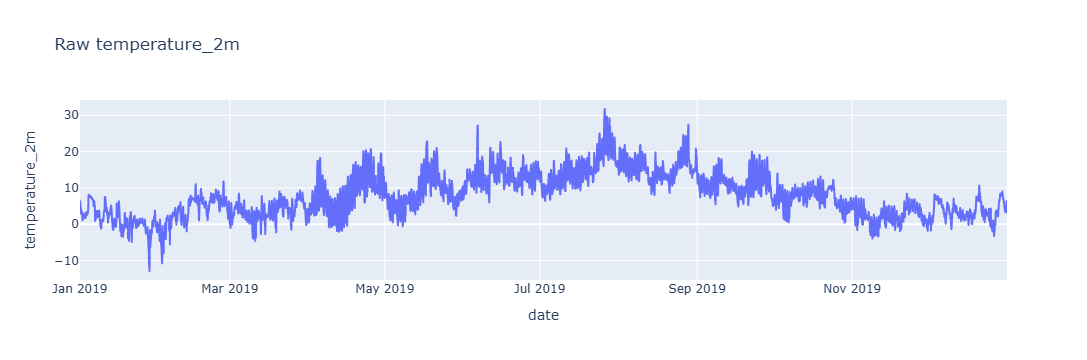

In [12]:
fig = px.line(df_hourly, x="date", y="temperature_2m", title='Raw temperature_2m')
fig.show()

In [13]:
def plot_summary_temperature(df, cutoff=100, k=3.0):
    """
    Input:
    df : pd.DataFrame
    cutoff : int
    k : float

    Returns
    -------
    fig : plotly.graph_objects.Figure
    summary : pd.DataFrame
    """

    df = df_hourly.copy()
    
    # High pass filtering
    temp_dct_ortho = dct(df.temperature_2m, norm='ortho')

    temp_dct_ortho[:cutoff] = 0
    df['temp_highpass'] = idct(temp_dct_ortho, norm='ortho')

    # Seasonally adjusted temperature variations
    median_satv = np.median(df['temp_highpass'])
    mad_satv = np.median(np.abs(df['temp_highpass'] - median_satv))
    
    k = 3.0  # typical SPC multiplier
    ucl = median_satv + k * mad_satv
    lcl = median_satv - k * mad_satv
    
    df['is_outlier'] = (df['temp_highpass'] > ucl) | (df['temp_highpass'] < lcl)

    # Plotting
    fig = go.Figure()
    
    # Original temperature_2m trace
    fig.add_trace(go.Scatter(
        x=df_hourly['date'],
        y=df_hourly['temperature_2m'],
        mode='lines',
        name='Original temperature'
    ))

# Seasonally adjusted (high-pass) temperature_2m (non-outliers)
#fig.add_trace(go.Scatter(
 #   x=df_hourly.loc[~df_hourly['is_outlier'], 'date'],
  #  y=df_hourly.loc[~df_hourly['is_outlier'], 'temperature_2m'],
   # mode='markers',
    #name='Inliers',
    #marker=dict(color='blue', size=4),
#))

    # Outliers
    fig.add_trace(go.Scatter(
        x=df.loc[df['is_outlier'], 'date'],
        y=df.loc[df['is_outlier'], 'temperature_2m'],
        mode='markers',
        name='Outliers',
        marker=dict(color='red', size=4, symbol='circle'),
    ))

    # SPC boundaries (horizontal lines)
    fig.add_trace(go.Scatter(
        x=[df['date'].min(), df['date'].max()],
        y=[ucl, ucl],
        mode='lines',
        name='UCL (Upper Control Limit)',
        line=dict(color='green', dash='dash')
    ))
    
    fig.add_trace(go.Scatter(
        x=[df['date'].min(), df['date'].max()],
        y=[lcl, lcl],
        mode='lines',
        name='LCL (Lower Control Limit)',
        line=dict(color='green', dash='dash')
    ))
    
    # Layout
    fig.update_layout(
        title='Temperature with SPC Outlier Detection (Seasonally Adjusted via DCT)',
        xaxis_title='Date',
        yaxis_title='Temperature (°C)',
        template='plotly_white',
        legend=dict(yanchor='top', y=0.98, xanchor='left', x=0.01),
        height=600
    )
    
    
    summary = df.loc[df['is_outlier'], ['date', 'temperature_2m', 'temp_highpass']].copy()
    summary['deviation'] = df.loc[df['is_outlier'], 'temp_highpass'] - median_satv
    summary['limit'] = np.where(summary['temp_highpass'] > ucl, 'above UCL', 'below LCL')

    return fig, summary

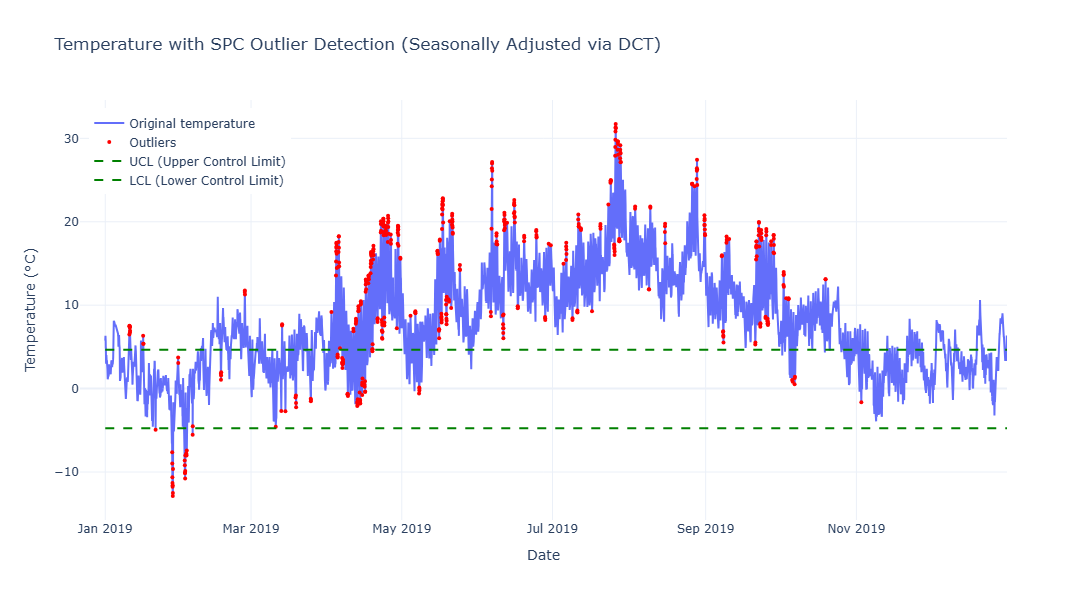

Outlier Summary:
                         date  temperature_2m  temp_highpass  deviation  \
234 2019-01-10 18:00:00+00:00           6.472       4.724131   4.764295   
235 2019-01-10 19:00:00+00:00           7.522       5.764941   5.805105   
236 2019-01-10 20:00:00+00:00           7.472       5.704797   5.744960   
237 2019-01-10 21:00:00+00:00           7.472       5.693722   5.733885   
238 2019-01-10 22:00:00+00:00           7.372       5.581739   5.621903   

         limit  
234  above UCL  
235  above UCL  
236  above UCL  
237  above UCL  
238  above UCL  

Total outliers detected: 491


In [14]:
fig, summary = plot_summary_temperature(df = df_hourly)

# Show results
fig.show()
print("Outlier Summary:")
print(summary.head())
print(f"\nTotal outliers detected: {len(summary)}")

In [15]:
def plot_precip_anomalies(df, outlier_fraction=0.01):
    
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    # Feature for anomaly detection
    X = df[["precipitation"]].values

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=outlier_fraction)
    labels = lof.fit_predict(X)
    df["anomaly"] = labels == -1
    
    anomalies = df[df["anomaly"]]
    normal = df[~df["anomaly"]]

    # Create Plotly figure 
    fig = go.Figure()

    # Normal points (blue line)
    fig.add_trace(go.Scatter(
        x=normal["date"], y=normal["precipitation"],
        mode="lines", name="Normal", line=dict(color="blue")
    ))

    # Anomalies (red markers)
    fig.add_trace(go.Scatter(
        x=anomalies["date"], y=anomalies["precipitation"],
        mode="markers", name="Anomaly",
        marker=dict(color="red", size=4, symbol="circle")
    ))

    fig.update_layout(
        title=f"Precipitation with Anomalies (LOF, {outlier_fraction*100:.1f}% expected outliers)",
        xaxis_title="Date-Time",
        yaxis_title="Precipitation",
        template="plotly_white",
        legend_title="Type"
    )

    summary_data = {
            "Total Points": [len(df)],
            "Detected Anomalies": [len(anomalies)],
            "Anomaly %": [len(anomalies) / len(df) * 100],
            "Normal Mean": [normal["precipitation"].mean()],
            "Anomaly Mean": [anomalies["precipitation"].mean()],
            "Anomaly Max": [anomalies["precipitation"].max()],
            "Anomaly Min": [anomalies["precipitation"].min()],
            "First Anomaly": [anomalies["date"].min()],
            "Last Anomaly": [anomalies["date"].max()]
        }
    summary = pd.DataFrame(summary_data)

    return fig, summary


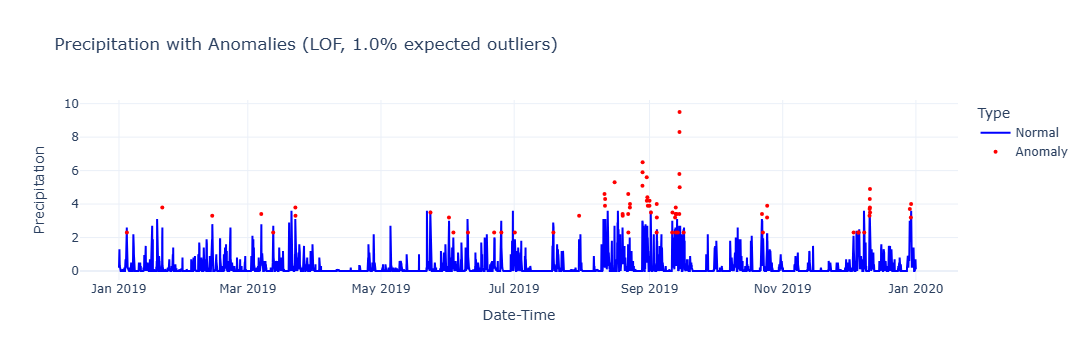

,Total Points,Detected Anomalies,Anomaly %,Normal Mean,Anomaly Mean,Anomaly Max,Anomaly Min,First Anomaly,Last Anomaly
0,8760,72,0.821918,0.218117,3.665278,9.5,2.3,2019-01-04 15:00:00+00:00,2019-12-29 19:00:00+00:00


In [16]:
fig, summary = plot_precip_anomalies(df_hourly)
fig.show()
summary

In [17]:
# Setting Cassandra environment
keyspace = 'my_first_keyspace'
table_name = 'elhub'

# Connecting to Cassandra
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace(f'{keyspace}')

WARNING	Task(Task-2) cassandra.cluster:cluster.py:__init__()- Cluster.__init__ called with contact_points specified, but no load_balancing_policy. In the next major version, this will raise an error; please specify a load-balancing policy. (contact_points = ['localhost'], lbp = None)
WARNING	Task(Task-2) cassandra.cluster:cluster.py:protocol_downgrade()- Downgrading core protocol version from 66 to 65 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
WARNING	Task(Task-2) cassandra.cluster:cluster.py:protocol_downgrade()- Downgrading core protocol version from 65 to 5 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster

In [18]:
# Start a Spark session
spark = (
    SparkSession.builder
    .appName('CassandraReader')
    .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1')
    .config('spark.cassandra.connection.host', 'localhost')  
    .config('spark.cassandra.connection.port', '9042')
    .getOrCreate()
)

In [19]:
# Collect the data from the Cassandra database
df_no = (
    spark.read
    .format('org.apache.spark.sql.cassandra')
    .options(table='elhub', keyspace='my_first_keyspace')
    .load()
    .select('pricearea', 'productiongroup', 'starttime', 'quantitykwh')
)

In [20]:
df_no = df_no.toPandas()

In [21]:
df_no.head()

,pricearea,productiongroup,starttime,quantitykwh
0,NO4,thermal,2021-07-09 09:00:00,20562.000
1,NO1,other,2021-08-21 01:00:00,0.000
2,NO3,solar,2021-11-08 22:00:00,34.530
3,NO3,solar,2021-01-13 15:00:00,18.292
4,NO3,other,2021-02-06 20:00:00,0.000


In [22]:
def _make_odd(x):
    """Return an odd integer >= 3 from x (int or None)."""
    if x is None:
        return None
    x = int(x)
    if x < 3:
        return 3
    return x if x % 2 == 1 else x + 1

def loess_decompose_and_plot(
    df,
    pricearea=None,
    productiongroup=None,
    period_length=24,
    seasonal_smoother=None,
    trend_smoother=None,
    robust=False,
    resample_rule=None,
    lowess_frac=0.1,
    ):

    """
    Seasonal trend decomposition (which uses local regression / loess internally),
    and plot original series, trend, seasonal and residual components.

    Parameters:
    df : pandas.DataFrame
    pricearea=None,
    productiongroup=None,
    period_length=24,
    seasonal_smoother=None,
    trend_smoother=None,
    robust=False,
    resample_rule=None,
    lowess_frac=0.1
    
    Returns:
    fig : matplotlib.figure.Figure
    """

    # Copy the dataframe an aggregate quantities by timestamp
    df = df.copy()
    df['starttime'] = pd.to_datetime(df['starttime'])
    df = df.sort_values('starttime')
    series = df.groupby('starttime')['quantitykwh'].sum()
    series = series.sort_index()
    n = len(series)

    # Prepare STL parameters
    seasonal = _make_odd(seasonal_smoother if seasonal_smoother is not None else period_length)
    trend = _make_odd(trend_smoother if trend_smoother is not None else max(7, int(period_length * 1.5)))
    
    # Ensure seasonal < n and trend < n
    seasonal = seasonal if (seasonal is None or seasonal < n) else _make_odd(max(3, n - 2))
    trend = trend if (trend is None or trend < n) else _make_odd(max(3, n - 2))

    stl = STL(series, period=period_length, seasonal=seasonal, trend=trend, robust=robust)
    res = stl.fit()
    
    lowess_sm = lowess(series.values, np.arange(n), frac=lowess_frac, return_sorted=False)

    # Plotting
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    
    # Original series
    axes[0].plot(series.index, series.values)
    axes[0].set_ylabel('quantitykwh')
    axes[0].set_title('Original series and LOWESS overlay')
    axes[0].plot(series.index, lowess_sm, linestyle='--')
    
    # Trend
    axes[1].plot(series.index, res.trend)
    axes[1].set_ylabel('Trend')
    
    # Seasonal
    axes[2].plot(series.index, res.seasonal)
    axes[2].set_ylabel('Seasonal')
    
    # Residual
    axes[3].plot(series.index, res.resid)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('time')
    
    
    plt.tight_layout()

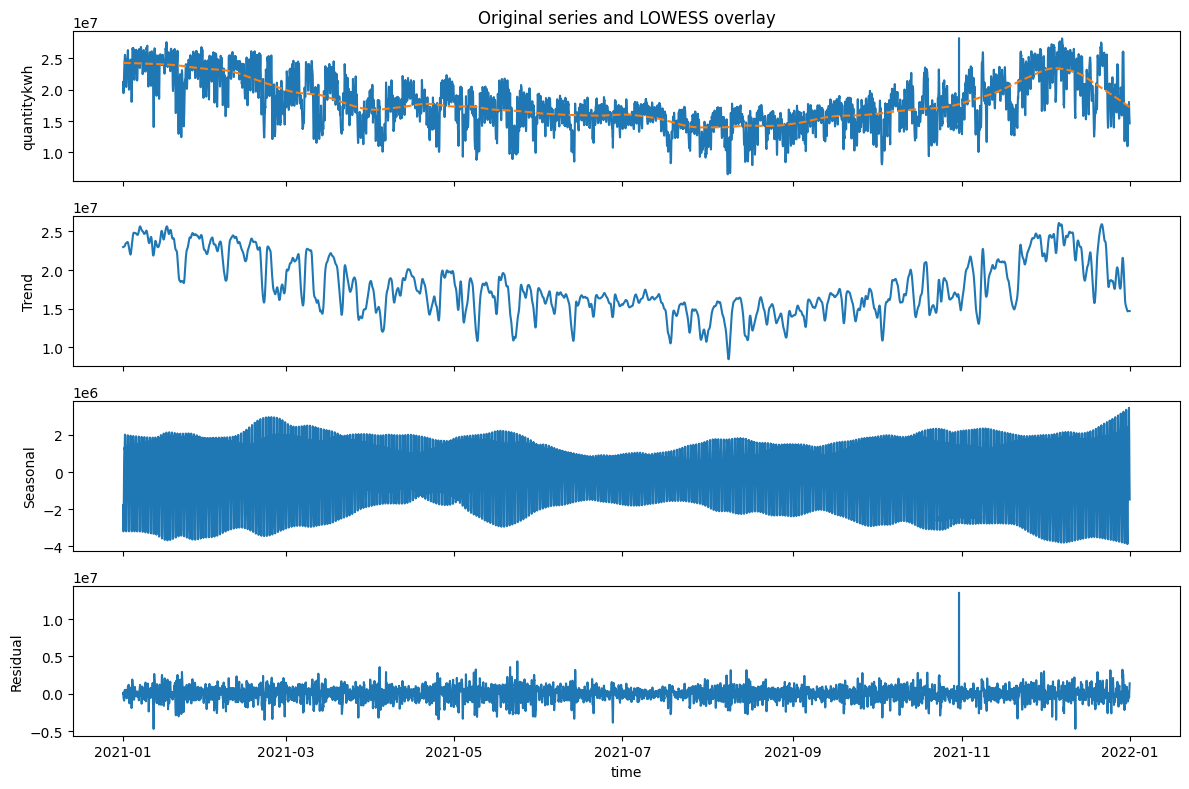

In [23]:
loess_decompose_and_plot(df_no)
plt.show()
#fig = res.plot()

In [24]:
def plot_spectrogram_stft(df, pricearea='NO1', productiongroup='hydro',
                          resample_freq='15min', window_length='2H', overlap=0.5):
    """
    Plot a spectrogram of energy production using scipy.signal.stft.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns ['starttime', 'pricearea', 'productiongroup', 'quantitykwh'].
    pricearea : str, default 'NO1'
        Filter for this price area.
    productiongroup : str, default 'Hydro'
        Filter for this production group.
    resample_freq : str, default '15min'
        Frequency to resample the data to uniform spacing.
    window_length : str, default '2H'
        Window length for STFT.
    overlap : float, default 0.5
        Overlap ratio between consecutive windows (0 < overlap < 1).

    Returns
    -------
    fig : matplotlib.figure.Figure

    """
    # Filter data
    dff = df[(df['pricearea'] == pricearea) & (df['productiongroup'] == productiongroup)].copy()
    if dff.empty:
        raise ValueError("No data for the given filters.")

    # Ensure datetime and sort
    dff['starttime'] = pd.to_datetime(dff['starttime'])
    dff.sort_values('starttime', inplace=True)
    dff.set_index('starttime', inplace=True)

    # Resample to a regular time step
    dff = dff['quantitykwh'].resample(resample_freq).mean().interpolate()
    signal = dff.values

    # Compute parameters for STFT
    fs = 1 / pd.to_timedelta(resample_freq).total_seconds()  # Sampling frequency [Hz]
    nperseg = int(pd.to_timedelta(window_length).total_seconds() / pd.to_timedelta(resample_freq).total_seconds())
    noverlap = int(nperseg * overlap)

    # Compute STFT
    f, t, Zxx = stft(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Plot spectrogram
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='viridis')

    ax.set_title(f"Spectrogram (STFT) for {productiongroup} in {pricearea}")
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    fig.colorbar(im, ax=ax, label='|Amplitude|')

    plt.tight_layout()
    return fig



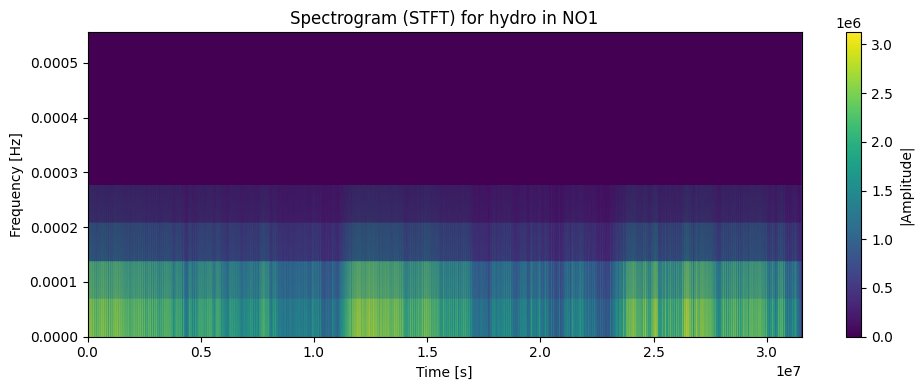

In [25]:
fig = plot_spectrogram_stft(df_no)
plt.show()